# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [8]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [13]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]
num_iterations = [500, 800, 1000, 1300, 1500, 1800]

results = {}
best_val = -1
best_svm = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for it in num_iterations:
    for lr in learning_rates:
        for r in regularization_strengths:
            svm = LinearSVM()
            loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=r,
                          num_iters=it, verbose=True)
            y_train_pred = svm.predict(X_train_feats)
            y_val_pred = svm.predict(X_val_feats)
            val_accuracy = np.mean(y_val == y_val_pred)
            if val_accuracy > best_val:
                best_val = val_accuracy
                best_svm = svm
            results[(lr, r)] = (np.mean(y_train == y_train_pred), val_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 500: loss 85.724010
iteration 100 / 500: loss 84.963305
iteration 200 / 500: loss 84.218669
iteration 300 / 500: loss 83.454612
iteration 400 / 500: loss 82.715036
iteration 0 / 500: loss 787.040869
iteration 100 / 500: loss 712.966385
iteration 200 / 500: loss 645.967689
iteration 300 / 500: loss 585.333888
iteration 400 / 500: loss 530.473758
iteration 0 / 500: loss 7759.613126
iteration 100 / 500: loss 2853.150106
iteration 200 / 500: loss 1052.682702
iteration 300 / 500: loss 391.988335
iteration 400 / 500: loss 149.541910
iteration 0 / 500: loss 86.663553
iteration 100 / 500: loss 79.275967
iteration 200 / 500: loss 72.565906
iteration 300 / 500: loss 66.530944
iteration 400 / 500: loss 61.041379
iteration 0 / 500: loss 790.634234
iteration 100 / 500: loss 295.822410
iteration 200 / 500: loss 114.252083
iteration 300 / 500: loss 47.618364
iteration 400 / 500: loss 23.172609
iteration 0 / 500: loss 7595.135023
iteration 100 / 500: loss 9.265959
iteration 200 / 500: lo

iteration 600 / 1300: loss 428.617639
iteration 700 / 1300: loss 388.679715
iteration 800 / 1300: loss 352.539268
iteration 900 / 1300: loss 319.837095
iteration 1000 / 1300: loss 290.252191
iteration 1100 / 1300: loss 263.481684
iteration 1200 / 1300: loss 239.252941
iteration 0 / 1300: loss 7805.907525
iteration 100 / 1300: loss 2870.138605
iteration 200 / 1300: loss 1058.919647
iteration 300 / 1300: loss 394.276589
iteration 400 / 1300: loss 150.380008
iteration 500 / 1300: loss 60.879605
iteration 600 / 1300: loss 28.038118
iteration 700 / 1300: loss 15.985856
iteration 800 / 1300: loss 11.563316
iteration 900 / 1300: loss 9.940500
iteration 1000 / 1300: loss 9.345129
iteration 1100 / 1300: loss 9.126613
iteration 1200 / 1300: loss 9.046476
iteration 0 / 1300: loss 81.357046
iteration 100 / 1300: loss 74.462960
iteration 200 / 1300: loss 68.236145
iteration 300 / 1300: loss 62.594622
iteration 400 / 1300: loss 57.489757
iteration 500 / 1300: loss 52.873142
iteration 600 / 1300: los

iteration 700 / 1500: loss 9.000005
iteration 800 / 1500: loss 9.000003
iteration 900 / 1500: loss 9.000004
iteration 1000 / 1500: loss 9.000003
iteration 1100 / 1500: loss 9.000005
iteration 1200 / 1500: loss 9.000006
iteration 1300 / 1500: loss 9.000007
iteration 1400 / 1500: loss 9.000004
iteration 0 / 1800: loss 81.954326
iteration 100 / 1800: loss 81.208749
iteration 200 / 1800: loss 80.503464
iteration 300 / 1800: loss 79.792020
iteration 400 / 1800: loss 79.086650
iteration 500 / 1800: loss 78.394318
iteration 600 / 1800: loss 77.710941
iteration 700 / 1800: loss 77.012951
iteration 800 / 1800: loss 76.339204
iteration 900 / 1800: loss 75.671752
iteration 1000 / 1800: loss 74.999530
iteration 1100 / 1800: loss 74.355542
iteration 1200 / 1800: loss 73.701222
iteration 1300 / 1800: loss 73.049276
iteration 1400 / 1800: loss 72.429232
iteration 1500 / 1800: loss 71.783678
iteration 1600 / 1800: loss 71.163775
iteration 1700 / 1800: loss 70.542358
iteration 0 / 1800: loss 801.296048

In [14]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.412


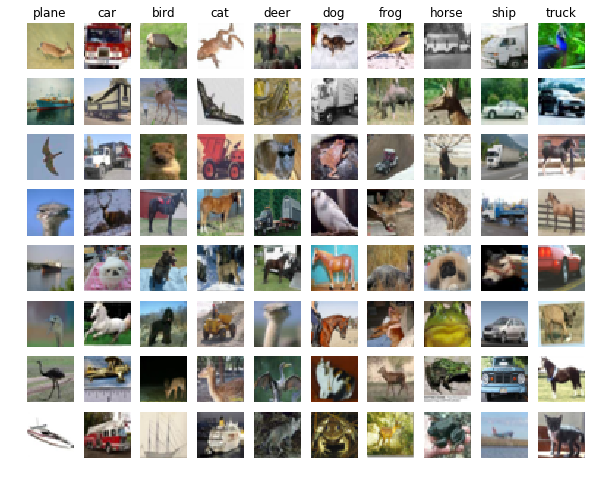

In [15]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [16]:
print(X_train_feats.shape)

(49000, 155)


In [20]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_score = 0.0

learning_rates = [1e-5, 0.1, 0.01, 0.001, 1e-4, 1e-6]
num_iterations = [500, 800, 1000, 1300, 1500, 1800]
decays = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
regularizations = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.55]
batch_sizes = [200]

for lr in learning_rates:
    for it in num_iterations:
        for decay in decays:
            for regu in regularizations:
                for bs in batch_sizes:
                
                    net = TwoLayerNet(input_dim, hidden_dim, num_classes)

                    # Train the network
                    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                                num_iters=it, batch_size=bs,
                                learning_rate=lr, learning_rate_decay=decay,
                                reg=regu, verbose=False)

                    # Predict on the validation set
                    val_acc = (net.predict(X_val_feats) == y_val).mean()
                    print('lr %f, it %f, decay %f, regu %f, bs %f, Validation accuracy: %f' % (lr, it, decay, regu, bs, val_acc))
                    
                    if val_acc > best_score:
                        print('BEST: lr %f, it %f, decay %f, regu %f, bs %f, Validation accuracy: %f' % (lr, it, decay, regu, bs, val_acc))
                        best_score = val_acc
                        best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 0.000010, it 500.000000, decay 0.500000, regu 0.100000, bs 200.000000, Validation accuracy: 0.093000
BEST: lr 0.000010, it 500.000000, decay 0.500000, regu 0.100000, bs 200.000000, Validation accuracy: 0.093000
lr 0.000010, it 500.000000, decay 0.500000, regu 0.150000, bs 200.000000, Validation accuracy: 0.108000
BEST: lr 0.000010, it 500.000000, decay 0.500000, regu 0.150000, bs 200.000000, Validation accuracy: 0.108000
lr 0.000010, it 500.000000, decay 0.500000, regu 0.200000, bs 200.000000, Validation accuracy: 0.109000
BEST: lr 0.000010, it 500.000000, decay 0.500000, regu 0.200000, bs 200.000000, Validation accuracy: 0.109000
lr 0.000010, it 500.000000, decay 0.500000, regu 0.250000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000010, it 500.000000, decay 0.500000, regu 0.300000, bs 200.000000, Validation accuracy: 0.096000
lr 0.000010, it 500.000000, decay 0.500000, regu 0.350000, bs 200.000000, Validation accuracy: 0.103000
lr 0.000010, it 500.000000, decay 0.500000, re

lr 0.000010, it 500.000000, decay 0.950000, regu 0.550000, bs 200.000000, Validation accuracy: 0.079000
lr 0.000010, it 500.000000, decay 0.990000, regu 0.100000, bs 200.000000, Validation accuracy: 0.092000
lr 0.000010, it 500.000000, decay 0.990000, regu 0.150000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000010, it 500.000000, decay 0.990000, regu 0.200000, bs 200.000000, Validation accuracy: 0.101000
lr 0.000010, it 500.000000, decay 0.990000, regu 0.250000, bs 200.000000, Validation accuracy: 0.077000
lr 0.000010, it 500.000000, decay 0.990000, regu 0.300000, bs 200.000000, Validation accuracy: 0.082000
lr 0.000010, it 500.000000, decay 0.990000, regu 0.350000, bs 200.000000, Validation accuracy: 0.114000
lr 0.000010, it 500.000000, decay 0.990000, regu 0.400000, bs 200.000000, Validation accuracy: 0.078000
lr 0.000010, it 500.000000, decay 0.990000, regu 0.500000, bs 200.000000, Validation accuracy: 0.092000
lr 0.000010, it 500.000000, decay 0.990000, regu 0.550000, bs 20

lr 0.000010, it 800.000000, decay 0.950000, regu 0.400000, bs 200.000000, Validation accuracy: 0.093000
lr 0.000010, it 800.000000, decay 0.950000, regu 0.500000, bs 200.000000, Validation accuracy: 0.077000
lr 0.000010, it 800.000000, decay 0.950000, regu 0.550000, bs 200.000000, Validation accuracy: 0.115000
lr 0.000010, it 800.000000, decay 0.990000, regu 0.100000, bs 200.000000, Validation accuracy: 0.099000
lr 0.000010, it 800.000000, decay 0.990000, regu 0.150000, bs 200.000000, Validation accuracy: 0.101000
lr 0.000010, it 800.000000, decay 0.990000, regu 0.200000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000010, it 800.000000, decay 0.990000, regu 0.250000, bs 200.000000, Validation accuracy: 0.089000
lr 0.000010, it 800.000000, decay 0.990000, regu 0.300000, bs 200.000000, Validation accuracy: 0.079000
lr 0.000010, it 800.000000, decay 0.990000, regu 0.350000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000010, it 800.000000, decay 0.990000, regu 0.400000, bs 20

lr 0.000010, it 1000.000000, decay 0.950000, regu 0.300000, bs 200.000000, Validation accuracy: 0.083000
lr 0.000010, it 1000.000000, decay 0.950000, regu 0.350000, bs 200.000000, Validation accuracy: 0.100000
lr 0.000010, it 1000.000000, decay 0.950000, regu 0.400000, bs 200.000000, Validation accuracy: 0.077000
lr 0.000010, it 1000.000000, decay 0.950000, regu 0.500000, bs 200.000000, Validation accuracy: 0.089000
lr 0.000010, it 1000.000000, decay 0.950000, regu 0.550000, bs 200.000000, Validation accuracy: 0.079000
lr 0.000010, it 1000.000000, decay 0.990000, regu 0.100000, bs 200.000000, Validation accuracy: 0.084000
lr 0.000010, it 1000.000000, decay 0.990000, regu 0.150000, bs 200.000000, Validation accuracy: 0.083000
lr 0.000010, it 1000.000000, decay 0.990000, regu 0.200000, bs 200.000000, Validation accuracy: 0.106000
lr 0.000010, it 1000.000000, decay 0.990000, regu 0.250000, bs 200.000000, Validation accuracy: 0.115000
lr 0.000010, it 1000.000000, decay 0.990000, regu 0.300

lr 0.000010, it 1300.000000, decay 0.950000, regu 0.200000, bs 200.000000, Validation accuracy: 0.080000
lr 0.000010, it 1300.000000, decay 0.950000, regu 0.250000, bs 200.000000, Validation accuracy: 0.085000
lr 0.000010, it 1300.000000, decay 0.950000, regu 0.300000, bs 200.000000, Validation accuracy: 0.113000
lr 0.000010, it 1300.000000, decay 0.950000, regu 0.350000, bs 200.000000, Validation accuracy: 0.126000
lr 0.000010, it 1300.000000, decay 0.950000, regu 0.400000, bs 200.000000, Validation accuracy: 0.079000
lr 0.000010, it 1300.000000, decay 0.950000, regu 0.500000, bs 200.000000, Validation accuracy: 0.083000
lr 0.000010, it 1300.000000, decay 0.950000, regu 0.550000, bs 200.000000, Validation accuracy: 0.099000
lr 0.000010, it 1300.000000, decay 0.990000, regu 0.100000, bs 200.000000, Validation accuracy: 0.085000
lr 0.000010, it 1300.000000, decay 0.990000, regu 0.150000, bs 200.000000, Validation accuracy: 0.081000
lr 0.000010, it 1300.000000, decay 0.990000, regu 0.200

lr 0.000010, it 1500.000000, decay 0.950000, regu 0.100000, bs 200.000000, Validation accuracy: 0.081000
lr 0.000010, it 1500.000000, decay 0.950000, regu 0.150000, bs 200.000000, Validation accuracy: 0.101000
lr 0.000010, it 1500.000000, decay 0.950000, regu 0.200000, bs 200.000000, Validation accuracy: 0.080000
lr 0.000010, it 1500.000000, decay 0.950000, regu 0.250000, bs 200.000000, Validation accuracy: 0.097000
lr 0.000010, it 1500.000000, decay 0.950000, regu 0.300000, bs 200.000000, Validation accuracy: 0.100000
lr 0.000010, it 1500.000000, decay 0.950000, regu 0.350000, bs 200.000000, Validation accuracy: 0.082000
lr 0.000010, it 1500.000000, decay 0.950000, regu 0.400000, bs 200.000000, Validation accuracy: 0.102000
lr 0.000010, it 1500.000000, decay 0.950000, regu 0.500000, bs 200.000000, Validation accuracy: 0.121000
lr 0.000010, it 1500.000000, decay 0.950000, regu 0.550000, bs 200.000000, Validation accuracy: 0.098000
lr 0.000010, it 1500.000000, decay 0.990000, regu 0.100

lr 0.000010, it 1800.000000, decay 0.900000, regu 0.500000, bs 200.000000, Validation accuracy: 0.082000
lr 0.000010, it 1800.000000, decay 0.900000, regu 0.550000, bs 200.000000, Validation accuracy: 0.079000
lr 0.000010, it 1800.000000, decay 0.950000, regu 0.100000, bs 200.000000, Validation accuracy: 0.091000
lr 0.000010, it 1800.000000, decay 0.950000, regu 0.150000, bs 200.000000, Validation accuracy: 0.100000
lr 0.000010, it 1800.000000, decay 0.950000, regu 0.200000, bs 200.000000, Validation accuracy: 0.078000
lr 0.000010, it 1800.000000, decay 0.950000, regu 0.250000, bs 200.000000, Validation accuracy: 0.078000
lr 0.000010, it 1800.000000, decay 0.950000, regu 0.300000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000010, it 1800.000000, decay 0.950000, regu 0.350000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000010, it 1800.000000, decay 0.950000, regu 0.400000, bs 200.000000, Validation accuracy: 0.078000
lr 0.000010, it 1800.000000, decay 0.950000, regu 0.500

lr 0.100000, it 500.000000, decay 0.900000, regu 0.150000, bs 200.000000, Validation accuracy: 0.286000
lr 0.100000, it 500.000000, decay 0.900000, regu 0.200000, bs 200.000000, Validation accuracy: 0.232000
lr 0.100000, it 500.000000, decay 0.900000, regu 0.250000, bs 200.000000, Validation accuracy: 0.194000
lr 0.100000, it 500.000000, decay 0.900000, regu 0.300000, bs 200.000000, Validation accuracy: 0.202000
lr 0.100000, it 500.000000, decay 0.900000, regu 0.350000, bs 200.000000, Validation accuracy: 0.105000
lr 0.100000, it 500.000000, decay 0.900000, regu 0.400000, bs 200.000000, Validation accuracy: 0.105000
lr 0.100000, it 500.000000, decay 0.900000, regu 0.500000, bs 200.000000, Validation accuracy: 0.087000
lr 0.100000, it 500.000000, decay 0.900000, regu 0.550000, bs 200.000000, Validation accuracy: 0.079000
lr 0.100000, it 500.000000, decay 0.950000, regu 0.100000, bs 200.000000, Validation accuracy: 0.311000
BEST: lr 0.100000, it 500.000000, decay 0.950000, regu 0.100000,

lr 0.100000, it 800.000000, decay 0.850000, regu 0.350000, bs 200.000000, Validation accuracy: 0.105000
lr 0.100000, it 800.000000, decay 0.850000, regu 0.400000, bs 200.000000, Validation accuracy: 0.079000
lr 0.100000, it 800.000000, decay 0.850000, regu 0.500000, bs 200.000000, Validation accuracy: 0.087000
lr 0.100000, it 800.000000, decay 0.850000, regu 0.550000, bs 200.000000, Validation accuracy: 0.079000
lr 0.100000, it 800.000000, decay 0.900000, regu 0.100000, bs 200.000000, Validation accuracy: 0.377000
BEST: lr 0.100000, it 800.000000, decay 0.900000, regu 0.100000, bs 200.000000, Validation accuracy: 0.377000
lr 0.100000, it 800.000000, decay 0.900000, regu 0.150000, bs 200.000000, Validation accuracy: 0.290000
lr 0.100000, it 800.000000, decay 0.900000, regu 0.200000, bs 200.000000, Validation accuracy: 0.274000
lr 0.100000, it 800.000000, decay 0.900000, regu 0.250000, bs 200.000000, Validation accuracy: 0.266000
lr 0.100000, it 800.000000, decay 0.900000, regu 0.300000,

lr 0.100000, it 1000.000000, decay 0.850000, regu 0.100000, bs 200.000000, Validation accuracy: 0.383000
lr 0.100000, it 1000.000000, decay 0.850000, regu 0.150000, bs 200.000000, Validation accuracy: 0.301000
lr 0.100000, it 1000.000000, decay 0.850000, regu 0.200000, bs 200.000000, Validation accuracy: 0.292000
lr 0.100000, it 1000.000000, decay 0.850000, regu 0.250000, bs 200.000000, Validation accuracy: 0.263000
lr 0.100000, it 1000.000000, decay 0.850000, regu 0.300000, bs 200.000000, Validation accuracy: 0.194000
lr 0.100000, it 1000.000000, decay 0.850000, regu 0.350000, bs 200.000000, Validation accuracy: 0.122000
lr 0.100000, it 1000.000000, decay 0.850000, regu 0.400000, bs 200.000000, Validation accuracy: 0.107000
lr 0.100000, it 1000.000000, decay 0.850000, regu 0.500000, bs 200.000000, Validation accuracy: 0.079000
lr 0.100000, it 1000.000000, decay 0.850000, regu 0.550000, bs 200.000000, Validation accuracy: 0.113000
lr 0.100000, it 1000.000000, decay 0.900000, regu 0.100

lr 0.100000, it 1300.000000, decay 0.800000, regu 0.250000, bs 200.000000, Validation accuracy: 0.283000
lr 0.100000, it 1300.000000, decay 0.800000, regu 0.300000, bs 200.000000, Validation accuracy: 0.190000
lr 0.100000, it 1300.000000, decay 0.800000, regu 0.350000, bs 200.000000, Validation accuracy: 0.170000
lr 0.100000, it 1300.000000, decay 0.800000, regu 0.400000, bs 200.000000, Validation accuracy: 0.119000
lr 0.100000, it 1300.000000, decay 0.800000, regu 0.500000, bs 200.000000, Validation accuracy: 0.113000
lr 0.100000, it 1300.000000, decay 0.800000, regu 0.550000, bs 200.000000, Validation accuracy: 0.098000
lr 0.100000, it 1300.000000, decay 0.850000, regu 0.100000, bs 200.000000, Validation accuracy: 0.420000
BEST: lr 0.100000, it 1300.000000, decay 0.850000, regu 0.100000, bs 200.000000, Validation accuracy: 0.420000
lr 0.100000, it 1300.000000, decay 0.850000, regu 0.150000, bs 200.000000, Validation accuracy: 0.312000
lr 0.100000, it 1300.000000, decay 0.850000, regu

lr 0.100000, it 1500.000000, decay 0.750000, regu 0.500000, bs 200.000000, Validation accuracy: 0.105000
lr 0.100000, it 1500.000000, decay 0.750000, regu 0.550000, bs 200.000000, Validation accuracy: 0.113000
lr 0.100000, it 1500.000000, decay 0.800000, regu 0.100000, bs 200.000000, Validation accuracy: 0.394000
lr 0.100000, it 1500.000000, decay 0.800000, regu 0.150000, bs 200.000000, Validation accuracy: 0.321000
lr 0.100000, it 1500.000000, decay 0.800000, regu 0.200000, bs 200.000000, Validation accuracy: 0.292000
lr 0.100000, it 1500.000000, decay 0.800000, regu 0.250000, bs 200.000000, Validation accuracy: 0.287000
lr 0.100000, it 1500.000000, decay 0.800000, regu 0.300000, bs 200.000000, Validation accuracy: 0.171000
lr 0.100000, it 1500.000000, decay 0.800000, regu 0.350000, bs 200.000000, Validation accuracy: 0.139000
lr 0.100000, it 1500.000000, decay 0.800000, regu 0.400000, bs 200.000000, Validation accuracy: 0.078000
lr 0.100000, it 1500.000000, decay 0.800000, regu 0.500

lr 0.100000, it 1800.000000, decay 0.750000, regu 0.350000, bs 200.000000, Validation accuracy: 0.197000
lr 0.100000, it 1800.000000, decay 0.750000, regu 0.400000, bs 200.000000, Validation accuracy: 0.107000
lr 0.100000, it 1800.000000, decay 0.750000, regu 0.500000, bs 200.000000, Validation accuracy: 0.098000
lr 0.100000, it 1800.000000, decay 0.750000, regu 0.550000, bs 200.000000, Validation accuracy: 0.079000
lr 0.100000, it 1800.000000, decay 0.800000, regu 0.100000, bs 200.000000, Validation accuracy: 0.392000
lr 0.100000, it 1800.000000, decay 0.800000, regu 0.150000, bs 200.000000, Validation accuracy: 0.309000
lr 0.100000, it 1800.000000, decay 0.800000, regu 0.200000, bs 200.000000, Validation accuracy: 0.303000
lr 0.100000, it 1800.000000, decay 0.800000, regu 0.250000, bs 200.000000, Validation accuracy: 0.283000
lr 0.100000, it 1800.000000, decay 0.800000, regu 0.300000, bs 200.000000, Validation accuracy: 0.204000
lr 0.100000, it 1800.000000, decay 0.800000, regu 0.350

lr 0.010000, it 500.000000, decay 0.750000, regu 0.250000, bs 200.000000, Validation accuracy: 0.098000
lr 0.010000, it 500.000000, decay 0.750000, regu 0.300000, bs 200.000000, Validation accuracy: 0.107000
lr 0.010000, it 500.000000, decay 0.750000, regu 0.350000, bs 200.000000, Validation accuracy: 0.102000
lr 0.010000, it 500.000000, decay 0.750000, regu 0.400000, bs 200.000000, Validation accuracy: 0.112000
lr 0.010000, it 500.000000, decay 0.750000, regu 0.500000, bs 200.000000, Validation accuracy: 0.078000
lr 0.010000, it 500.000000, decay 0.750000, regu 0.550000, bs 200.000000, Validation accuracy: 0.078000
lr 0.010000, it 500.000000, decay 0.800000, regu 0.100000, bs 200.000000, Validation accuracy: 0.078000
lr 0.010000, it 500.000000, decay 0.800000, regu 0.150000, bs 200.000000, Validation accuracy: 0.087000
lr 0.010000, it 500.000000, decay 0.800000, regu 0.200000, bs 200.000000, Validation accuracy: 0.105000
lr 0.010000, it 500.000000, decay 0.800000, regu 0.250000, bs 20

lr 0.010000, it 800.000000, decay 0.750000, regu 0.150000, bs 200.000000, Validation accuracy: 0.087000
lr 0.010000, it 800.000000, decay 0.750000, regu 0.200000, bs 200.000000, Validation accuracy: 0.098000
lr 0.010000, it 800.000000, decay 0.750000, regu 0.250000, bs 200.000000, Validation accuracy: 0.078000
lr 0.010000, it 800.000000, decay 0.750000, regu 0.300000, bs 200.000000, Validation accuracy: 0.078000
lr 0.010000, it 800.000000, decay 0.750000, regu 0.350000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 800.000000, decay 0.750000, regu 0.400000, bs 200.000000, Validation accuracy: 0.102000
lr 0.010000, it 800.000000, decay 0.750000, regu 0.500000, bs 200.000000, Validation accuracy: 0.098000
lr 0.010000, it 800.000000, decay 0.750000, regu 0.550000, bs 200.000000, Validation accuracy: 0.087000
lr 0.010000, it 800.000000, decay 0.800000, regu 0.100000, bs 200.000000, Validation accuracy: 0.113000
lr 0.010000, it 800.000000, decay 0.800000, regu 0.150000, bs 20

lr 0.010000, it 1000.000000, decay 0.700000, regu 0.550000, bs 200.000000, Validation accuracy: 0.119000
lr 0.010000, it 1000.000000, decay 0.750000, regu 0.100000, bs 200.000000, Validation accuracy: 0.078000
lr 0.010000, it 1000.000000, decay 0.750000, regu 0.150000, bs 200.000000, Validation accuracy: 0.119000
lr 0.010000, it 1000.000000, decay 0.750000, regu 0.200000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 1000.000000, decay 0.750000, regu 0.250000, bs 200.000000, Validation accuracy: 0.087000
lr 0.010000, it 1000.000000, decay 0.750000, regu 0.300000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 1000.000000, decay 0.750000, regu 0.350000, bs 200.000000, Validation accuracy: 0.098000
lr 0.010000, it 1000.000000, decay 0.750000, regu 0.400000, bs 200.000000, Validation accuracy: 0.087000
lr 0.010000, it 1000.000000, decay 0.750000, regu 0.500000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 1000.000000, decay 0.750000, regu 0.550

lr 0.010000, it 1300.000000, decay 0.700000, regu 0.400000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 1300.000000, decay 0.700000, regu 0.500000, bs 200.000000, Validation accuracy: 0.105000
lr 0.010000, it 1300.000000, decay 0.700000, regu 0.550000, bs 200.000000, Validation accuracy: 0.102000
lr 0.010000, it 1300.000000, decay 0.750000, regu 0.100000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 1300.000000, decay 0.750000, regu 0.150000, bs 200.000000, Validation accuracy: 0.087000
lr 0.010000, it 1300.000000, decay 0.750000, regu 0.200000, bs 200.000000, Validation accuracy: 0.102000
lr 0.010000, it 1300.000000, decay 0.750000, regu 0.250000, bs 200.000000, Validation accuracy: 0.107000
lr 0.010000, it 1300.000000, decay 0.750000, regu 0.300000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 1300.000000, decay 0.750000, regu 0.350000, bs 200.000000, Validation accuracy: 0.098000
lr 0.010000, it 1300.000000, decay 0.750000, regu 0.400

lr 0.010000, it 1500.000000, decay 0.700000, regu 0.300000, bs 200.000000, Validation accuracy: 0.087000
lr 0.010000, it 1500.000000, decay 0.700000, regu 0.350000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 1500.000000, decay 0.700000, regu 0.400000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 1500.000000, decay 0.700000, regu 0.500000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 1500.000000, decay 0.700000, regu 0.550000, bs 200.000000, Validation accuracy: 0.112000
lr 0.010000, it 1500.000000, decay 0.750000, regu 0.100000, bs 200.000000, Validation accuracy: 0.078000
lr 0.010000, it 1500.000000, decay 0.750000, regu 0.150000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 1500.000000, decay 0.750000, regu 0.200000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 1500.000000, decay 0.750000, regu 0.250000, bs 200.000000, Validation accuracy: 0.107000
lr 0.010000, it 1500.000000, decay 0.750000, regu 0.300

lr 0.010000, it 1800.000000, decay 0.700000, regu 0.200000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 1800.000000, decay 0.700000, regu 0.250000, bs 200.000000, Validation accuracy: 0.078000
lr 0.010000, it 1800.000000, decay 0.700000, regu 0.300000, bs 200.000000, Validation accuracy: 0.107000
lr 0.010000, it 1800.000000, decay 0.700000, regu 0.350000, bs 200.000000, Validation accuracy: 0.087000
lr 0.010000, it 1800.000000, decay 0.700000, regu 0.400000, bs 200.000000, Validation accuracy: 0.102000
lr 0.010000, it 1800.000000, decay 0.700000, regu 0.500000, bs 200.000000, Validation accuracy: 0.107000
lr 0.010000, it 1800.000000, decay 0.700000, regu 0.550000, bs 200.000000, Validation accuracy: 0.079000
lr 0.010000, it 1800.000000, decay 0.750000, regu 0.100000, bs 200.000000, Validation accuracy: 0.119000
lr 0.010000, it 1800.000000, decay 0.750000, regu 0.150000, bs 200.000000, Validation accuracy: 0.087000
lr 0.010000, it 1800.000000, decay 0.750000, regu 0.200

lr 0.001000, it 500.000000, decay 0.700000, regu 0.100000, bs 200.000000, Validation accuracy: 0.087000
lr 0.001000, it 500.000000, decay 0.700000, regu 0.150000, bs 200.000000, Validation accuracy: 0.112000
lr 0.001000, it 500.000000, decay 0.700000, regu 0.200000, bs 200.000000, Validation accuracy: 0.078000
lr 0.001000, it 500.000000, decay 0.700000, regu 0.250000, bs 200.000000, Validation accuracy: 0.105000
lr 0.001000, it 500.000000, decay 0.700000, regu 0.300000, bs 200.000000, Validation accuracy: 0.105000
lr 0.001000, it 500.000000, decay 0.700000, regu 0.350000, bs 200.000000, Validation accuracy: 0.087000
lr 0.001000, it 500.000000, decay 0.700000, regu 0.400000, bs 200.000000, Validation accuracy: 0.098000
lr 0.001000, it 500.000000, decay 0.700000, regu 0.500000, bs 200.000000, Validation accuracy: 0.113000
lr 0.001000, it 500.000000, decay 0.700000, regu 0.550000, bs 200.000000, Validation accuracy: 0.105000
lr 0.001000, it 500.000000, decay 0.750000, regu 0.100000, bs 20

lr 0.001000, it 800.000000, decay 0.600000, regu 0.500000, bs 200.000000, Validation accuracy: 0.078000
lr 0.001000, it 800.000000, decay 0.600000, regu 0.550000, bs 200.000000, Validation accuracy: 0.079000
lr 0.001000, it 800.000000, decay 0.700000, regu 0.100000, bs 200.000000, Validation accuracy: 0.079000
lr 0.001000, it 800.000000, decay 0.700000, regu 0.150000, bs 200.000000, Validation accuracy: 0.078000
lr 0.001000, it 800.000000, decay 0.700000, regu 0.200000, bs 200.000000, Validation accuracy: 0.100000
lr 0.001000, it 800.000000, decay 0.700000, regu 0.250000, bs 200.000000, Validation accuracy: 0.113000
lr 0.001000, it 800.000000, decay 0.700000, regu 0.300000, bs 200.000000, Validation accuracy: 0.107000
lr 0.001000, it 800.000000, decay 0.700000, regu 0.350000, bs 200.000000, Validation accuracy: 0.079000
lr 0.001000, it 800.000000, decay 0.700000, regu 0.400000, bs 200.000000, Validation accuracy: 0.107000
lr 0.001000, it 800.000000, decay 0.700000, regu 0.500000, bs 20

lr 0.001000, it 1000.000000, decay 0.600000, regu 0.350000, bs 200.000000, Validation accuracy: 0.102000
lr 0.001000, it 1000.000000, decay 0.600000, regu 0.400000, bs 200.000000, Validation accuracy: 0.078000
lr 0.001000, it 1000.000000, decay 0.600000, regu 0.500000, bs 200.000000, Validation accuracy: 0.105000
lr 0.001000, it 1000.000000, decay 0.600000, regu 0.550000, bs 200.000000, Validation accuracy: 0.079000
lr 0.001000, it 1000.000000, decay 0.700000, regu 0.100000, bs 200.000000, Validation accuracy: 0.078000
lr 0.001000, it 1000.000000, decay 0.700000, regu 0.150000, bs 200.000000, Validation accuracy: 0.087000
lr 0.001000, it 1000.000000, decay 0.700000, regu 0.200000, bs 200.000000, Validation accuracy: 0.087000
lr 0.001000, it 1000.000000, decay 0.700000, regu 0.250000, bs 200.000000, Validation accuracy: 0.087000
lr 0.001000, it 1000.000000, decay 0.700000, regu 0.300000, bs 200.000000, Validation accuracy: 0.079000
lr 0.001000, it 1000.000000, decay 0.700000, regu 0.350

lr 0.001000, it 1300.000000, decay 0.600000, regu 0.250000, bs 200.000000, Validation accuracy: 0.078000
lr 0.001000, it 1300.000000, decay 0.600000, regu 0.300000, bs 200.000000, Validation accuracy: 0.079000
lr 0.001000, it 1300.000000, decay 0.600000, regu 0.350000, bs 200.000000, Validation accuracy: 0.107000
lr 0.001000, it 1300.000000, decay 0.600000, regu 0.400000, bs 200.000000, Validation accuracy: 0.078000
lr 0.001000, it 1300.000000, decay 0.600000, regu 0.500000, bs 200.000000, Validation accuracy: 0.079000
lr 0.001000, it 1300.000000, decay 0.600000, regu 0.550000, bs 200.000000, Validation accuracy: 0.078000
lr 0.001000, it 1300.000000, decay 0.700000, regu 0.100000, bs 200.000000, Validation accuracy: 0.102000
lr 0.001000, it 1300.000000, decay 0.700000, regu 0.150000, bs 200.000000, Validation accuracy: 0.102000
lr 0.001000, it 1300.000000, decay 0.700000, regu 0.200000, bs 200.000000, Validation accuracy: 0.087000
lr 0.001000, it 1300.000000, decay 0.700000, regu 0.250

lr 0.001000, it 1500.000000, decay 0.600000, regu 0.150000, bs 200.000000, Validation accuracy: 0.105000
lr 0.001000, it 1500.000000, decay 0.600000, regu 0.200000, bs 200.000000, Validation accuracy: 0.112000
lr 0.001000, it 1500.000000, decay 0.600000, regu 0.250000, bs 200.000000, Validation accuracy: 0.078000
lr 0.001000, it 1500.000000, decay 0.600000, regu 0.300000, bs 200.000000, Validation accuracy: 0.079000
lr 0.001000, it 1500.000000, decay 0.600000, regu 0.350000, bs 200.000000, Validation accuracy: 0.113000
lr 0.001000, it 1500.000000, decay 0.600000, regu 0.400000, bs 200.000000, Validation accuracy: 0.102000
lr 0.001000, it 1500.000000, decay 0.600000, regu 0.500000, bs 200.000000, Validation accuracy: 0.078000
lr 0.001000, it 1500.000000, decay 0.600000, regu 0.550000, bs 200.000000, Validation accuracy: 0.079000
lr 0.001000, it 1500.000000, decay 0.700000, regu 0.100000, bs 200.000000, Validation accuracy: 0.112000
lr 0.001000, it 1500.000000, decay 0.700000, regu 0.150

lr 0.001000, it 1800.000000, decay 0.500000, regu 0.550000, bs 200.000000, Validation accuracy: 0.078000
lr 0.001000, it 1800.000000, decay 0.600000, regu 0.100000, bs 200.000000, Validation accuracy: 0.079000
lr 0.001000, it 1800.000000, decay 0.600000, regu 0.150000, bs 200.000000, Validation accuracy: 0.102000
lr 0.001000, it 1800.000000, decay 0.600000, regu 0.200000, bs 200.000000, Validation accuracy: 0.112000
lr 0.001000, it 1800.000000, decay 0.600000, regu 0.250000, bs 200.000000, Validation accuracy: 0.087000
lr 0.001000, it 1800.000000, decay 0.600000, regu 0.300000, bs 200.000000, Validation accuracy: 0.078000
lr 0.001000, it 1800.000000, decay 0.600000, regu 0.350000, bs 200.000000, Validation accuracy: 0.087000
lr 0.001000, it 1800.000000, decay 0.600000, regu 0.400000, bs 200.000000, Validation accuracy: 0.079000
lr 0.001000, it 1800.000000, decay 0.600000, regu 0.500000, bs 200.000000, Validation accuracy: 0.079000
lr 0.001000, it 1800.000000, decay 0.600000, regu 0.550

lr 0.000100, it 500.000000, decay 0.500000, regu 0.400000, bs 200.000000, Validation accuracy: 0.103000
lr 0.000100, it 500.000000, decay 0.500000, regu 0.500000, bs 200.000000, Validation accuracy: 0.105000
lr 0.000100, it 500.000000, decay 0.500000, regu 0.550000, bs 200.000000, Validation accuracy: 0.111000
lr 0.000100, it 500.000000, decay 0.600000, regu 0.100000, bs 200.000000, Validation accuracy: 0.107000
lr 0.000100, it 500.000000, decay 0.600000, regu 0.150000, bs 200.000000, Validation accuracy: 0.098000
lr 0.000100, it 500.000000, decay 0.600000, regu 0.200000, bs 200.000000, Validation accuracy: 0.078000
lr 0.000100, it 500.000000, decay 0.600000, regu 0.250000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000100, it 500.000000, decay 0.600000, regu 0.300000, bs 200.000000, Validation accuracy: 0.078000
lr 0.000100, it 500.000000, decay 0.600000, regu 0.350000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000100, it 500.000000, decay 0.600000, regu 0.400000, bs 20

lr 0.000100, it 800.000000, decay 0.500000, regu 0.300000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000100, it 800.000000, decay 0.500000, regu 0.350000, bs 200.000000, Validation accuracy: 0.078000
lr 0.000100, it 800.000000, decay 0.500000, regu 0.400000, bs 200.000000, Validation accuracy: 0.079000
lr 0.000100, it 800.000000, decay 0.500000, regu 0.500000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000100, it 800.000000, decay 0.500000, regu 0.550000, bs 200.000000, Validation accuracy: 0.119000
lr 0.000100, it 800.000000, decay 0.600000, regu 0.100000, bs 200.000000, Validation accuracy: 0.098000
lr 0.000100, it 800.000000, decay 0.600000, regu 0.150000, bs 200.000000, Validation accuracy: 0.117000
lr 0.000100, it 800.000000, decay 0.600000, regu 0.200000, bs 200.000000, Validation accuracy: 0.079000
lr 0.000100, it 800.000000, decay 0.600000, regu 0.250000, bs 200.000000, Validation accuracy: 0.098000
lr 0.000100, it 800.000000, decay 0.600000, regu 0.300000, bs 20

lr 0.000100, it 1000.000000, decay 0.500000, regu 0.200000, bs 200.000000, Validation accuracy: 0.098000
lr 0.000100, it 1000.000000, decay 0.500000, regu 0.250000, bs 200.000000, Validation accuracy: 0.097000
lr 0.000100, it 1000.000000, decay 0.500000, regu 0.300000, bs 200.000000, Validation accuracy: 0.105000
lr 0.000100, it 1000.000000, decay 0.500000, regu 0.350000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000100, it 1000.000000, decay 0.500000, regu 0.400000, bs 200.000000, Validation accuracy: 0.101000
lr 0.000100, it 1000.000000, decay 0.500000, regu 0.500000, bs 200.000000, Validation accuracy: 0.108000
lr 0.000100, it 1000.000000, decay 0.500000, regu 0.550000, bs 200.000000, Validation accuracy: 0.113000
lr 0.000100, it 1000.000000, decay 0.600000, regu 0.100000, bs 200.000000, Validation accuracy: 0.107000
lr 0.000100, it 1000.000000, decay 0.600000, regu 0.150000, bs 200.000000, Validation accuracy: 0.102000
lr 0.000100, it 1000.000000, decay 0.600000, regu 0.200

lr 0.000100, it 1300.000000, decay 0.500000, regu 0.100000, bs 200.000000, Validation accuracy: 0.078000
lr 0.000100, it 1300.000000, decay 0.500000, regu 0.150000, bs 200.000000, Validation accuracy: 0.078000
lr 0.000100, it 1300.000000, decay 0.500000, regu 0.200000, bs 200.000000, Validation accuracy: 0.102000
lr 0.000100, it 1300.000000, decay 0.500000, regu 0.250000, bs 200.000000, Validation accuracy: 0.103000
lr 0.000100, it 1300.000000, decay 0.500000, regu 0.300000, bs 200.000000, Validation accuracy: 0.113000
lr 0.000100, it 1300.000000, decay 0.500000, regu 0.350000, bs 200.000000, Validation accuracy: 0.097000
lr 0.000100, it 1300.000000, decay 0.500000, regu 0.400000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000100, it 1300.000000, decay 0.500000, regu 0.500000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000100, it 1300.000000, decay 0.500000, regu 0.550000, bs 200.000000, Validation accuracy: 0.112000
lr 0.000100, it 1300.000000, decay 0.600000, regu 0.100

lr 0.000100, it 1300.000000, decay 0.990000, regu 0.500000, bs 200.000000, Validation accuracy: 0.119000
lr 0.000100, it 1300.000000, decay 0.990000, regu 0.550000, bs 200.000000, Validation accuracy: 0.079000
lr 0.000100, it 1500.000000, decay 0.500000, regu 0.100000, bs 200.000000, Validation accuracy: 0.089000
lr 0.000100, it 1500.000000, decay 0.500000, regu 0.150000, bs 200.000000, Validation accuracy: 0.081000
lr 0.000100, it 1500.000000, decay 0.500000, regu 0.200000, bs 200.000000, Validation accuracy: 0.087000
lr 0.000100, it 1500.000000, decay 0.500000, regu 0.250000, bs 200.000000, Validation accuracy: 0.078000
lr 0.000100, it 1500.000000, decay 0.500000, regu 0.300000, bs 200.000000, Validation accuracy: 0.107000
lr 0.000100, it 1500.000000, decay 0.500000, regu 0.350000, bs 200.000000, Validation accuracy: 0.106000
lr 0.000100, it 1500.000000, decay 0.500000, regu 0.400000, bs 200.000000, Validation accuracy: 0.107000
lr 0.000100, it 1500.000000, decay 0.500000, regu 0.500

lr 0.000100, it 1500.000000, decay 0.990000, regu 0.350000, bs 200.000000, Validation accuracy: 0.113000
lr 0.000100, it 1500.000000, decay 0.990000, regu 0.400000, bs 200.000000, Validation accuracy: 0.078000
lr 0.000100, it 1500.000000, decay 0.990000, regu 0.500000, bs 200.000000, Validation accuracy: 0.079000
lr 0.000100, it 1500.000000, decay 0.990000, regu 0.550000, bs 200.000000, Validation accuracy: 0.098000
lr 0.000100, it 1800.000000, decay 0.500000, regu 0.100000, bs 200.000000, Validation accuracy: 0.102000
lr 0.000100, it 1800.000000, decay 0.500000, regu 0.150000, bs 200.000000, Validation accuracy: 0.108000
lr 0.000100, it 1800.000000, decay 0.500000, regu 0.200000, bs 200.000000, Validation accuracy: 0.119000
lr 0.000100, it 1800.000000, decay 0.500000, regu 0.250000, bs 200.000000, Validation accuracy: 0.119000
lr 0.000100, it 1800.000000, decay 0.500000, regu 0.300000, bs 200.000000, Validation accuracy: 0.107000
lr 0.000100, it 1800.000000, decay 0.500000, regu 0.350

lr 0.000100, it 1800.000000, decay 0.990000, regu 0.250000, bs 200.000000, Validation accuracy: 0.078000
lr 0.000100, it 1800.000000, decay 0.990000, regu 0.300000, bs 200.000000, Validation accuracy: 0.105000
lr 0.000100, it 1800.000000, decay 0.990000, regu 0.350000, bs 200.000000, Validation accuracy: 0.078000
lr 0.000100, it 1800.000000, decay 0.990000, regu 0.400000, bs 200.000000, Validation accuracy: 0.079000
lr 0.000100, it 1800.000000, decay 0.990000, regu 0.500000, bs 200.000000, Validation accuracy: 0.113000
lr 0.000100, it 1800.000000, decay 0.990000, regu 0.550000, bs 200.000000, Validation accuracy: 0.079000
lr 0.000001, it 500.000000, decay 0.500000, regu 0.100000, bs 200.000000, Validation accuracy: 0.115000
lr 0.000001, it 500.000000, decay 0.500000, regu 0.150000, bs 200.000000, Validation accuracy: 0.099000
lr 0.000001, it 500.000000, decay 0.500000, regu 0.200000, bs 200.000000, Validation accuracy: 0.099000
lr 0.000001, it 500.000000, decay 0.500000, regu 0.250000,

lr 0.000001, it 500.000000, decay 0.990000, regu 0.150000, bs 200.000000, Validation accuracy: 0.090000
lr 0.000001, it 500.000000, decay 0.990000, regu 0.200000, bs 200.000000, Validation accuracy: 0.094000
lr 0.000001, it 500.000000, decay 0.990000, regu 0.250000, bs 200.000000, Validation accuracy: 0.119000
lr 0.000001, it 500.000000, decay 0.990000, regu 0.300000, bs 200.000000, Validation accuracy: 0.100000
lr 0.000001, it 500.000000, decay 0.990000, regu 0.350000, bs 200.000000, Validation accuracy: 0.096000
lr 0.000001, it 500.000000, decay 0.990000, regu 0.400000, bs 200.000000, Validation accuracy: 0.095000
lr 0.000001, it 500.000000, decay 0.990000, regu 0.500000, bs 200.000000, Validation accuracy: 0.102000
lr 0.000001, it 500.000000, decay 0.990000, regu 0.550000, bs 200.000000, Validation accuracy: 0.102000
lr 0.000001, it 800.000000, decay 0.500000, regu 0.100000, bs 200.000000, Validation accuracy: 0.089000
lr 0.000001, it 800.000000, decay 0.500000, regu 0.150000, bs 20

lr 0.000001, it 800.000000, decay 0.950000, regu 0.550000, bs 200.000000, Validation accuracy: 0.096000
lr 0.000001, it 800.000000, decay 0.990000, regu 0.100000, bs 200.000000, Validation accuracy: 0.072000
lr 0.000001, it 800.000000, decay 0.990000, regu 0.150000, bs 200.000000, Validation accuracy: 0.094000
lr 0.000001, it 800.000000, decay 0.990000, regu 0.200000, bs 200.000000, Validation accuracy: 0.079000
lr 0.000001, it 800.000000, decay 0.990000, regu 0.250000, bs 200.000000, Validation accuracy: 0.112000
lr 0.000001, it 800.000000, decay 0.990000, regu 0.300000, bs 200.000000, Validation accuracy: 0.095000
lr 0.000001, it 800.000000, decay 0.990000, regu 0.350000, bs 200.000000, Validation accuracy: 0.132000
lr 0.000001, it 800.000000, decay 0.990000, regu 0.400000, bs 200.000000, Validation accuracy: 0.099000
lr 0.000001, it 800.000000, decay 0.990000, regu 0.500000, bs 200.000000, Validation accuracy: 0.100000
lr 0.000001, it 800.000000, decay 0.990000, regu 0.550000, bs 20

lr 0.000001, it 1000.000000, decay 0.950000, regu 0.400000, bs 200.000000, Validation accuracy: 0.098000
lr 0.000001, it 1000.000000, decay 0.950000, regu 0.500000, bs 200.000000, Validation accuracy: 0.096000
lr 0.000001, it 1000.000000, decay 0.950000, regu 0.550000, bs 200.000000, Validation accuracy: 0.099000
lr 0.000001, it 1000.000000, decay 0.990000, regu 0.100000, bs 200.000000, Validation accuracy: 0.095000
lr 0.000001, it 1000.000000, decay 0.990000, regu 0.150000, bs 200.000000, Validation accuracy: 0.075000
lr 0.000001, it 1000.000000, decay 0.990000, regu 0.200000, bs 200.000000, Validation accuracy: 0.092000
lr 0.000001, it 1000.000000, decay 0.990000, regu 0.250000, bs 200.000000, Validation accuracy: 0.108000
lr 0.000001, it 1000.000000, decay 0.990000, regu 0.300000, bs 200.000000, Validation accuracy: 0.080000
lr 0.000001, it 1000.000000, decay 0.990000, regu 0.350000, bs 200.000000, Validation accuracy: 0.073000
lr 0.000001, it 1000.000000, decay 0.990000, regu 0.400

lr 0.000001, it 1300.000000, decay 0.950000, regu 0.300000, bs 200.000000, Validation accuracy: 0.110000
lr 0.000001, it 1300.000000, decay 0.950000, regu 0.350000, bs 200.000000, Validation accuracy: 0.110000
lr 0.000001, it 1300.000000, decay 0.950000, regu 0.400000, bs 200.000000, Validation accuracy: 0.107000
lr 0.000001, it 1300.000000, decay 0.950000, regu 0.500000, bs 200.000000, Validation accuracy: 0.096000
lr 0.000001, it 1300.000000, decay 0.950000, regu 0.550000, bs 200.000000, Validation accuracy: 0.101000
lr 0.000001, it 1300.000000, decay 0.990000, regu 0.100000, bs 200.000000, Validation accuracy: 0.111000
lr 0.000001, it 1300.000000, decay 0.990000, regu 0.150000, bs 200.000000, Validation accuracy: 0.094000
lr 0.000001, it 1300.000000, decay 0.990000, regu 0.200000, bs 200.000000, Validation accuracy: 0.089000
lr 0.000001, it 1300.000000, decay 0.990000, regu 0.250000, bs 200.000000, Validation accuracy: 0.077000
lr 0.000001, it 1300.000000, decay 0.990000, regu 0.300

lr 0.000001, it 1500.000000, decay 0.950000, regu 0.200000, bs 200.000000, Validation accuracy: 0.116000
lr 0.000001, it 1500.000000, decay 0.950000, regu 0.250000, bs 200.000000, Validation accuracy: 0.126000
lr 0.000001, it 1500.000000, decay 0.950000, regu 0.300000, bs 200.000000, Validation accuracy: 0.112000
lr 0.000001, it 1500.000000, decay 0.950000, regu 0.350000, bs 200.000000, Validation accuracy: 0.110000
lr 0.000001, it 1500.000000, decay 0.950000, regu 0.400000, bs 200.000000, Validation accuracy: 0.093000
lr 0.000001, it 1500.000000, decay 0.950000, regu 0.500000, bs 200.000000, Validation accuracy: 0.096000
lr 0.000001, it 1500.000000, decay 0.950000, regu 0.550000, bs 200.000000, Validation accuracy: 0.117000
lr 0.000001, it 1500.000000, decay 0.990000, regu 0.100000, bs 200.000000, Validation accuracy: 0.076000
lr 0.000001, it 1500.000000, decay 0.990000, regu 0.150000, bs 200.000000, Validation accuracy: 0.080000
lr 0.000001, it 1500.000000, decay 0.990000, regu 0.200

lr 0.000001, it 1800.000000, decay 0.950000, regu 0.100000, bs 200.000000, Validation accuracy: 0.067000
lr 0.000001, it 1800.000000, decay 0.950000, regu 0.150000, bs 200.000000, Validation accuracy: 0.066000
lr 0.000001, it 1800.000000, decay 0.950000, regu 0.200000, bs 200.000000, Validation accuracy: 0.079000
lr 0.000001, it 1800.000000, decay 0.950000, regu 0.250000, bs 200.000000, Validation accuracy: 0.124000
lr 0.000001, it 1800.000000, decay 0.950000, regu 0.300000, bs 200.000000, Validation accuracy: 0.106000
lr 0.000001, it 1800.000000, decay 0.950000, regu 0.350000, bs 200.000000, Validation accuracy: 0.105000
lr 0.000001, it 1800.000000, decay 0.950000, regu 0.400000, bs 200.000000, Validation accuracy: 0.118000
lr 0.000001, it 1800.000000, decay 0.950000, regu 0.500000, bs 200.000000, Validation accuracy: 0.114000
lr 0.000001, it 1800.000000, decay 0.950000, regu 0.550000, bs 200.000000, Validation accuracy: 0.101000
lr 0.000001, it 1800.000000, decay 0.990000, regu 0.100

In [22]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.424


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!